## Emergency vs Non-Emergency Audio Classification Project

##Done By: Ashwath Bala S

Table of Contents:

1. Problem Statement

2. Data Dictionary

3. Importing the Required Libraries

4. Loading the Audio Data

5. Preparing and Visualizing the Data

6. Creating training and validation set

7. Defining the Model Architecture with Model Compiling and Model Checkpointing

8. Model Training

9. Model Evaluation

10. Model Predictions



##1. Problem Statement

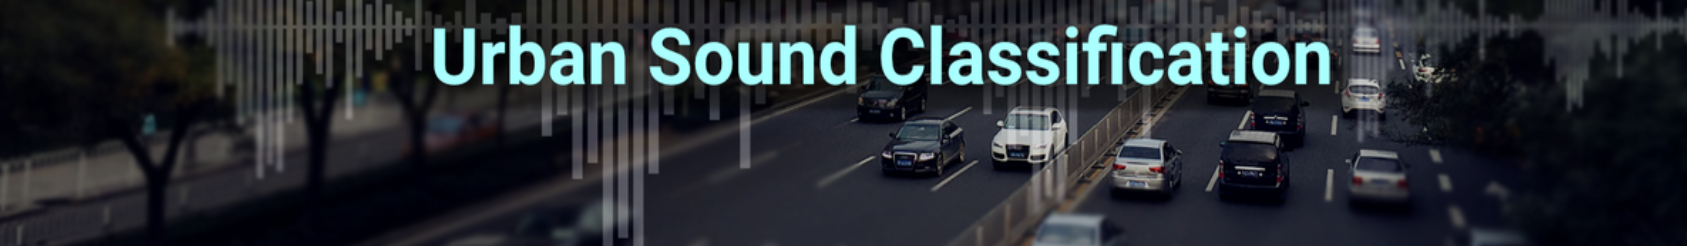

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance. Many accident victims wait for help at the site, and a delay costs them their lives. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams.

The solution to the above problem is to create a system that automatically detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

##2. Data Dictionary:

The Dataset used for this project are the audio files containing records of Emergency vs Non-Emergency

##3. Importing the Required Libraries

In [53]:
# For audio processing
import librosa
import scipy

In [2]:
# For playing audio
import IPython.display as ipd

# For array processing
import numpy as np

# For visualization
import matplotlib.pyplot as plt

##4. Loading the Audio Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Path to the Emergency File
emergency_path = '/content/drive/My Drive/Emergency_vs_Non-Emergency/emergency.wav'

# Load the audio file
emergency, sample_rate = librosa.load(emergency_path, sr=16000)

In [15]:
# Path to the Non-Emergency File
non_emergency_path = '/content/drive/My Drive/Emergency_vs_Non-Emergency/non emergency.wav'

non_emergency,sample_rate = librosa.load(non_emergency_path, sr =16000)

We have used the sampling rate (sr) of 16000 to read the above audio data. An audio wave of 2 seconds with a sampling rate of 16,000 will have 32,000 samples.

__Find the duration of the audio clips__

In [18]:
# Calculating the duration of the audio files in seconds
duration1 = librosa.get_duration(y=emergency, sr=16000)
duration2 = librosa.get_duration(y=non_emergency, sr=16000)

# Converting the durations to minutes
duration1_minutes = duration1 / 60
duration2_minutes = duration2 / 60

# Printing the durations
print("Duration of an emergency audio (in min):", duration1_minutes)
print("Duration of a non-emergency audio (in min):", duration2_minutes)

Duration of an emergency audio (in min): 22.920290625
Duration of a non-emergency audio (in min): 27.160834375


##5. Preparing and Visualizing the Data

# Preparing Data

Let us break the audio into chunks of 2 seconds. So, let us define the function for the same task

In [19]:
def prepare_data(audio_data, num_of_samples=32000, sr=16000):

  data=[]
  for offset in range(0, len(audio_data), sr):
    start = offset
    end   = offset + num_of_samples
    chunk = audio_data[start:end]

    if(len(chunk)==32000):
      data.append(chunk)

  return data

Calling the above functions

In [20]:
# prepare audio chunks
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [21]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Lets listen to some of the clips

In [22]:
ipd.Audio(emergency[136],rate=16000)

In [23]:
ipd.Audio(non_emergency[10],rate=16000)

# Visualization of Audio Data

Let's visualize the audio wave in time domain

Text(0, 0.5, 'Amplitude')

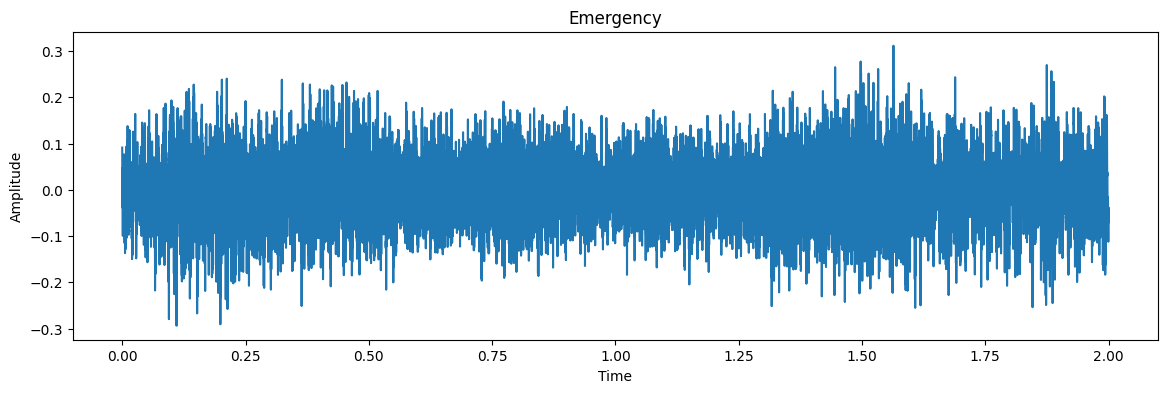

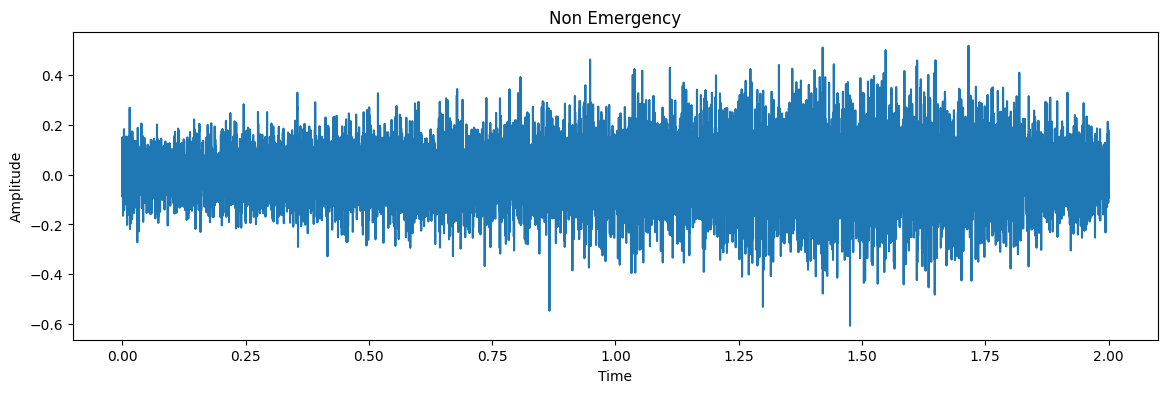

In [24]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

__Combine Emergecy and Non Emergency chunks__

In [25]:
audio = np.concatenate([emergency,non_emergency])

In [26]:
# assign labels
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate labels
labels = np.concatenate([labels1,labels2])

Taking a glance at the shape of the combined data.

In [27]:
print(audio.shape)

(3002, 32000)


##6. Creating training and validation set

In [28]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                            stratify=labels,test_size = 0.1,
                                            random_state=777,shuffle=True)

In [29]:
x_tr.shape, x_val.shape

((2701, 32000), (301, 32000))

The input must be 3 dimensional array - (no. of examples, timesteps, features)

So, lets reshape our input array according to the required shape

In [30]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


##7. Defining the Model Architecture with Model Compiling and Model Checkpointing

Let's define the model architecture using conv1D layers  and the time domain features.

__Call the model__

In [36]:
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, GlobalMaxPool1D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# CNN based deep learning model architecture
def conv_model(x_tr):

    inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))

    # First Conv1D layer
    conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
    conv = Dropout(0.3)(conv)
    conv = MaxPooling1D(2)(conv)

    # Second Conv1D layer
    conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    conv = MaxPooling1D(2)(conv)

    # Global MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)

    # Dense Layer
    conv = Dense(16, activation='relu')(conv)
    outputs = Dense(1, activation='sigmoid')(conv)

    model = Model(inputs, outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    return model, model_checkpoint

In [37]:
model, model_checkpoint = conv_model(x_tr_features)

Understand the shape and parameters at each layer

In [38]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 32000, 8)            │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32000, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 16000, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 16000, 16)           │           1,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16000, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 8000, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,825 (7.13 KB)

 Trainable params: 1,825 (7.13 KB)

 Non-trainable params: 0 (0.00 B)

##8. Model Training

Lets train the model for 10 epochs:

In [39]:
# model training
history = model.fit(x_tr_features, y_tr ,epochs=10,
                    callbacks=[model_checkpoint], batch_size=32,
                    validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - acc: 0.6148 - loss: 0.6660
Epoch 1: val_loss improved from inf to 0.61175, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 84s 963ms/step - acc: 0.6157 - loss: 0.6656 - val_acc: 0.7741 - val_loss: 0.6118
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7776 - loss: 0.5336
Epoch 2: val_loss improved from 0.61175 to 0.52582, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.7778 - loss: 0.5332 - val_acc: 0.8173 - val_loss: 0.5258
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - acc: 0.8353 - loss: 0.4335
Epoch 3: val_loss improved from 0.52582 to 0.46380, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 131s 960ms/step - acc: 0.8355 - loss: 0.4333 - val_acc: 0.8339 - val_loss: 0.4638
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - acc: 0.8636 - loss: 0.3640
Epoch 4: val_loss improved from 0.46380 to 0.41392, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━

In [41]:
# loading the best model weights
model.load_weights('best_model.keras')

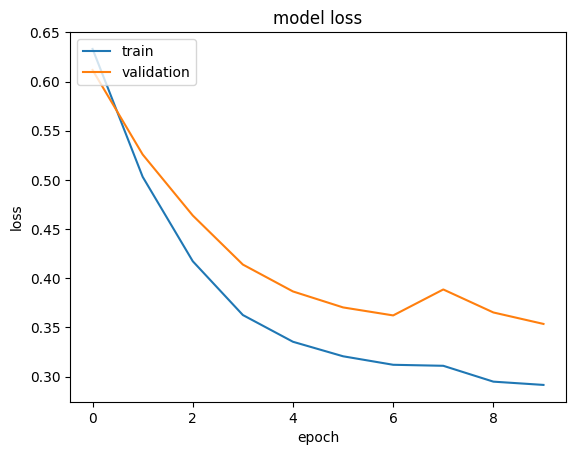

In [52]:
# Summarizing history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##9. Model Evaluation

In [43]:
_, acc = model.evaluate(x_val_features, y_val)
print("Validation Accuracy:", acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - acc: 0.8823 - loss: 0.3397
Validation Accuracy: 0.8704319000244141


##10. Model Prediction

In [44]:
# input audio

ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [45]:
# classification
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5):
  pred='emergency'
else:
  pred='non emergency'

print("Prediction:",pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Prediction: emergency


Our Model has correctly identified that the audio is emergency classification

##In this Project, we have built Deep Learning Model to classify Audio Data as Emergency or Non-Emergency